In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.svm import LinearSVC

In [3]:
%matplotlib inline

In [157]:
users = pd.read_csv('train_users_2.csv')
users = users[users["country_destination"] != "NDF"][users["country_destination"] != "other"]
print(users.shape)
users.head()

(78814, 16)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US


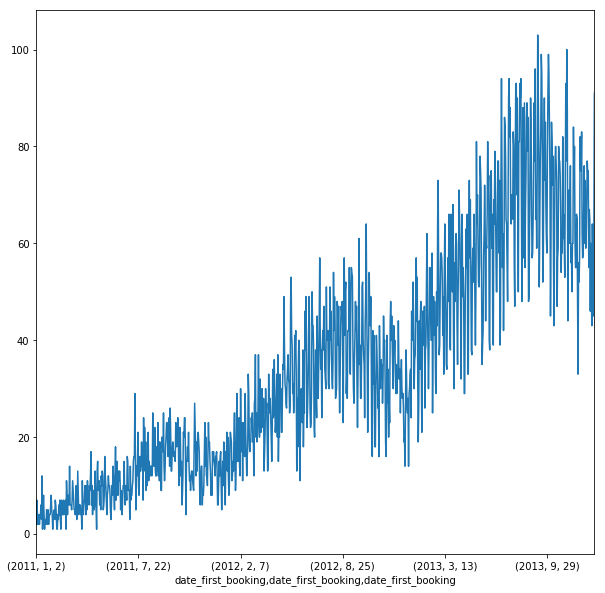

In [134]:
# dfb = users["date_first_booking"].str.split('-', expand=True).rename(columns={0: "year", 1: "month", 2: "day"})
# pd.to_datetime(dfb)
users["date_first_booking"] = pd.to_datetime(users["date_first_booking"])
dfb = users[users["country_destination"] == "US"]["date_first_booking"]
dfb_sub = dfb[(dfb.dt.year >= 2011) & (dfb.dt.year <= 2013)]
# Drop in the middle of summer 2014 due to train/test split
dfb_sub.groupby([dfb_sub.dt.year, dfb_sub.dt.month, dfb_sub.dt.day]).count().plot(figsize=(10,10))

In [136]:
dfb_sub = dfb[dfb.dt.year == 2013]
dfb.groupby([dfb_sub.dt.year, dfb_sub.dt.month, dfb_sub.dt.day]).count().sort_values(ascending=False).head()

date_first_booking  date_first_booking  date_first_booking
2013.0              9.0                 11.0                  103
                    11.0                7.0                   100
                    9.0                 18.0                   99
                    10.0                2.0                    99
                    9.0                 6.0                    96
Name: date_first_booking, dtype: int64

In [156]:
dfb_sub = dfb[(dfb.dt.year == 2013) & (dfb.dt.month >= 8)]
dfb.groupby([dfb_sub.dt.year, dfb_sub.dt.month, dfb_sub.dt.day]).count().sort_values(ascending=True).head()

date_first_booking  date_first_booking  date_first_booking
2013.0              11.0                29.0                  33
                    10.0                13.0                  43
                    12.0                26.0                  43
                    11.0                9.0                   44
                    12.0                29.0                  45
Name: date_first_booking, dtype: int64

In [24]:
# Remove NaN
aged_users = users[users["age"] == users["age"]]
print(aged_users.shape)
print((users.shape[0] - aged_users.shape[0]) / users.shape[0], "of ages missing")
aged_users.head()

(60956, 16)
0.22658410942218388 of ages missing


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


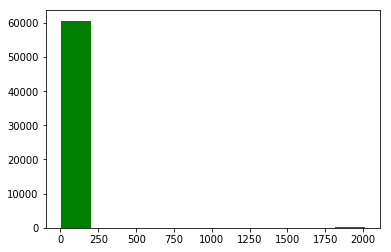

In [140]:
# oops, unreasonable data
foo = plt.hist(aged_users["age"], facecolor='g')

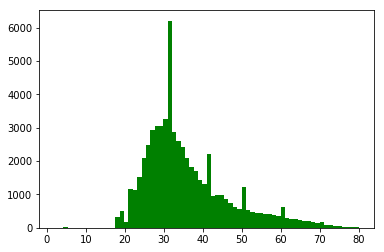

In [141]:
# histogram ages
aged_users = aged_users[aged_users["age"] <= 80]
foo = plt.hist(aged_users["age"], 70, facecolor='g')

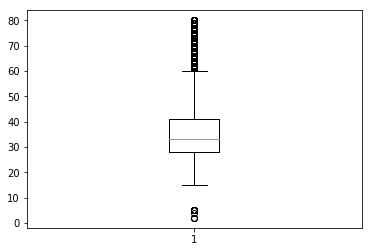

In [142]:
# also boxchart it
data_to_plot = [aged_users["age"]]
foo = plt.boxplot(data_to_plot)

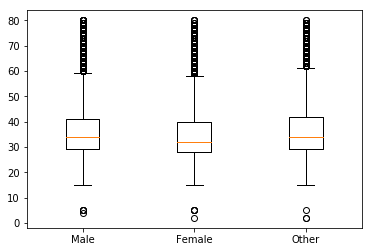

In [143]:
male_aged_users = aged_users[aged_users["gender"] == "MALE"]
female_aged_users = aged_users[aged_users["gender"] == "FEMALE"]
other_aged_users = aged_users[aged_users["gender"].str.contains('unknown')]
data_to_plot = [male_aged_users["age"], female_aged_users["age"], other_aged_users["age"]]
foo = plt.boxplot(data_to_plot, labels=["Male", "Female", "Other"])

In [144]:
male_count = users[users["gender"] == "MALE"].shape[0]
female_count = users[users["gender"] == "FEMALE"].shape[0]
print(male_count/users.shape[0], "percent male. ", female_count/users.shape[0], "percent female")

0.3080417184764128 percent male.  0.3658360189813992 percent female


In [145]:
# modes for ages
count = np.bincount(aged_users["age"].astype(np.int64)).tolist()
[count.index(i) for i in sorted(count, reverse=True)[:10]]

[30, 31, 32, 29, 28, 27, 33, 34, 26, 35]

In [155]:
# what about just female?
count = np.bincount(female_aged_users["age"].astype(np.int64)).tolist()
[count.index(i) for i in sorted(count, reverse=True)[:10]]

[27, 30, 28, 29, 32, 31, 33, 26, 25, 34]

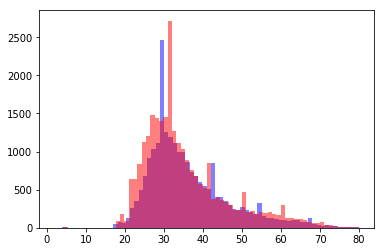

In [150]:
# age distribution by gender
plt.hist(male_aged_users["age"], 70, fc=(0, 0, 1, 0.5))
foo = plt.hist(female_aged_users["age"], 70, fc=(1, 0, 0, 0.5))

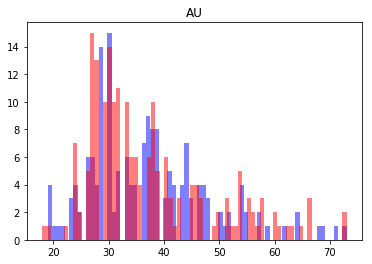

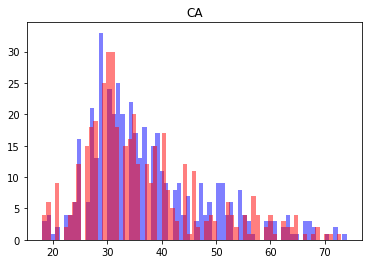

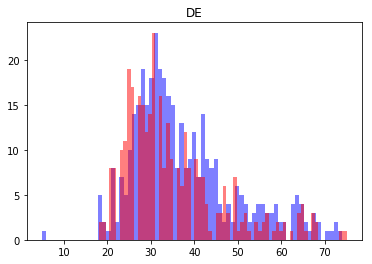

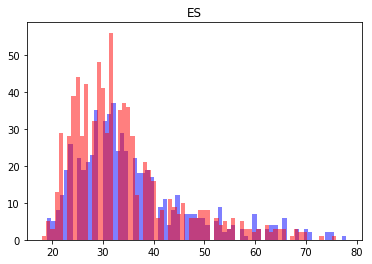

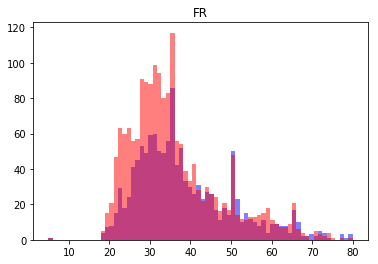

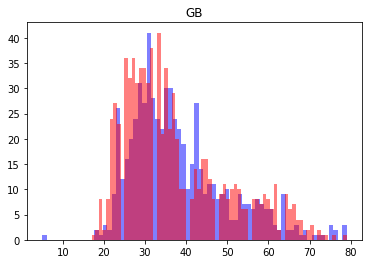

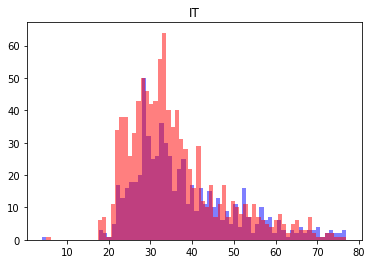

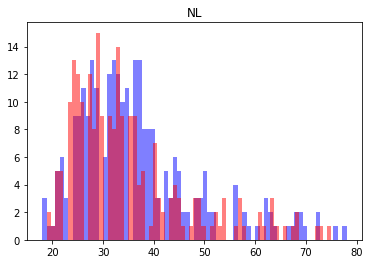

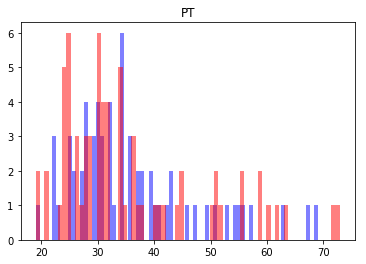

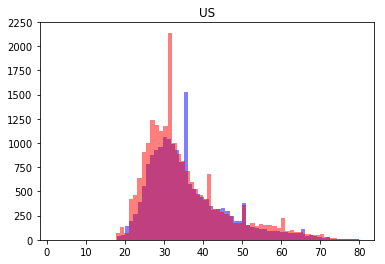

In [158]:
dests = np.unique(users["country_destination"])
for i in range(len(dests)):
    plt.figure(i)
    plt.title(dests[i])
    # plt.hist(other_aged_users[other_aged_users["country_destination"] == dests[i]]["age"], 70, fc=(0, 1, 0, 0.5))
    plt.hist(male_aged_users[male_aged_users["country_destination"] == dests[i]]["age"], 70, fc=(0, 0, 1, 0.5))
    plt.hist(female_aged_users[female_aged_users["country_destination"] == dests[i]]["age"], 70, fc=(1, 0, 0, 0.5))

In [157]:
np.unique(users["first_device_type"])

array(['Android Phone', 'Android Tablet', 'Desktop (Other)', 'Mac Desktop',
       'Other/Unknown', 'SmartPhone (Other)', 'Windows Desktop', 'iPad',
       'iPhone'], dtype=object)

In [163]:
for device in np.unique(users["first_device_type"]):
    print(device, users[users["first_device_type"] == device].shape[0])

Android Phone 634
Android Tablet 395
Desktop (Other) 490
Mac Desktop 37849
Other/Unknown 2592
SmartPhone (Other) 23
Windows Desktop 26320
iPad 4796
iPhone 5715


In [169]:
for device in np.unique(users["language"]):
    print(device, users[users["language"] == device].shape[0])

ca 2
cs 7
da 17
de 252
el 5
en 76870
es 228
fi 6
fr 380
hu 3
is 1
it 97
ja 73
ko 183
nl 29
no 12
pl 11
pt 44
ru 96
sv 37
th 3
tr 16
zh 442


In [200]:
for device in np.unique(users["country_destination"]):
    print(device, users[users["country_destination"] == device].shape[0]/users["country_destination"].shape[0])

AU 0.006838886492247571
CA 0.018118608369071483
DE 0.013462075265815719
ES 0.02853553937117771
FR 0.06373233181921993
GB 0.029487146953586927
IT 0.035970766615068386
NL 0.00966833303727764
PT 0.0027533179384373334
US 0.7914329941380973


In [204]:
isMale = np.vectorize(lambda g: 1 if g == "MALE" else 0)
isFemale = np.vectorize(lambda g: 1 if g == "FEMALE" else 0)
X = np.vstack([aged_users["age"], isMale(aged_users["gender"]), isFemale(aged_users["gender"]), np.ones([1, aged_users.shape[0]])]).T

dest_map = {dests[k]: k for k in range(len(dests))}
dest_vec = np.vectorize(lambda dest: dest_map[dest])
y = dest_vec(aged_users["country_destination"])

In [205]:
svm = LinearSVC(dual=False)
svm.fit(X, y)
y_hat = svm.predict(X)

# worse than random guessing haha
np.sum(y == y_hat)/y.shape[0]

0.7973831024141802

In [203]:
svm = LinearSVC(penalty="l1", dual=False)
svm.fit(X, y)
y_hat = svm.predict(X)
np.sum(y == y_hat)/y.shape[0]

0.7973831024141802